# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

In [3]:
print(df.isnull().sum())

market_id                   0
created_at                  0
actual_delivery_time        0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_dashers       0
total_busy_dashers          0
total_outstanding_orders    0
distance                    0
dtype: int64


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [4]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [5]:
# Convert categorical features to category type
df['store_primary_category'] = df['store_primary_category'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [6]:
# Calculate time taken in minutes
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [7]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_day'] = df['created_at'].dt.dayofweek # Monday=0, Sunday=6

# Create a categorical feature 'isWeekend'
df['is_weekend'] = (df['order_day'] >= 5).astype(int) # Weekend=1


In [8]:
# Drop unnecessary columns
df = df[df['delivery_duration'] > 0]


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [9]:
# Define target variable (y) and features (X)
X = df.drop(['delivery_duration'], axis=1)
y = df['delivery_duration']


# Create target variable: 1 if late, else 0

df['on_time_delivery'] = (df['delivery_duration'] <= 45).astype(int)
df['late_delivery'] = (df['delivery_duration'] > 45).astype(int)


# Check the new column

df[['delivery_duration', 'late_delivery']].head()


delivery_duration  late_delivery
0               47.0              1
1               44.0              0
2               55.0              1
3               59.0              1
4               46.0              1

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [10]:
# Split data into training and testing sets
# from sklearn.model_selection import train_test_split

X = df.drop(['late_delivery', 'delivery_duration'], axis=1)
y = df['late_delivery']

In [11]:
# Splitting the data: 80% training, 20% testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Check the shape of the splits
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

X_train shape: (140621, 18)
X_test shape : (35156, 18)
y_train shape: (140621,)
y_test shape : (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [12]:
# Define numerical and categorical columns for easy EDA and data manipulation

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['delivery_duration', 'late_delivery']]


print("Categorical columns:")
print(categorical_cols)

print("\nNumerical columns:")
print(numerical_cols)

Categorical columns:
['store_primary_category', 'order_protocol']

Numerical columns:
['market_id', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

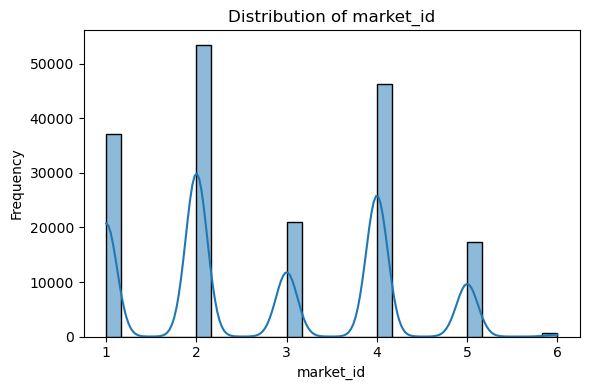

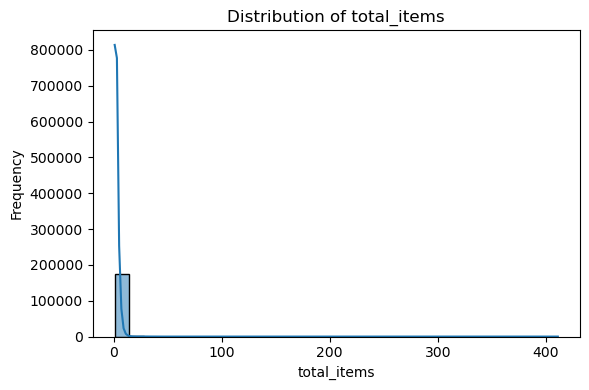

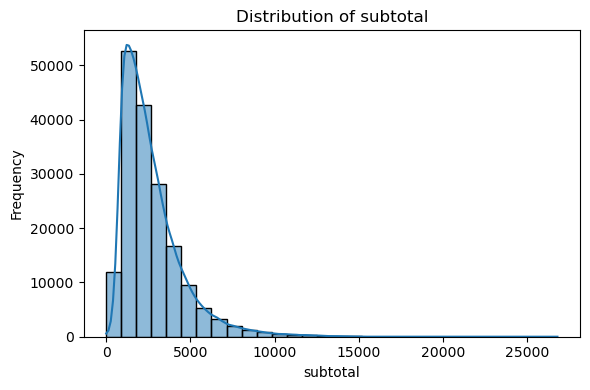

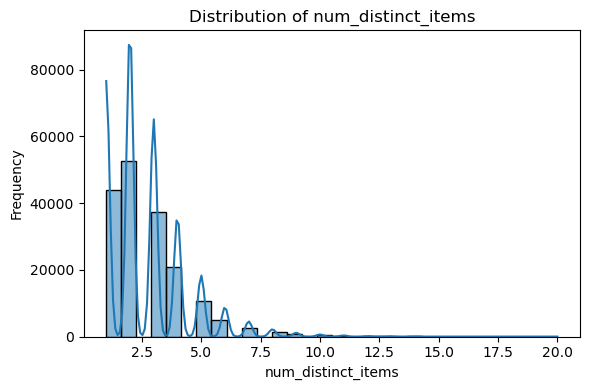

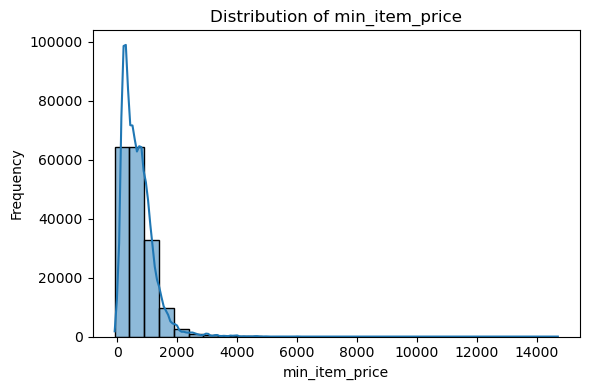

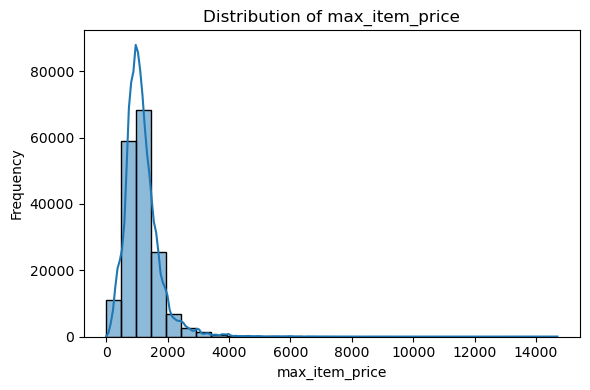

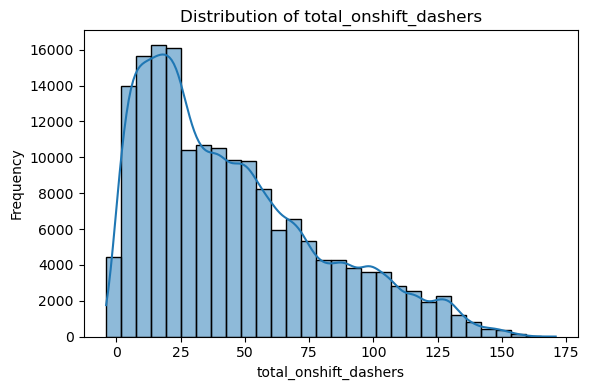

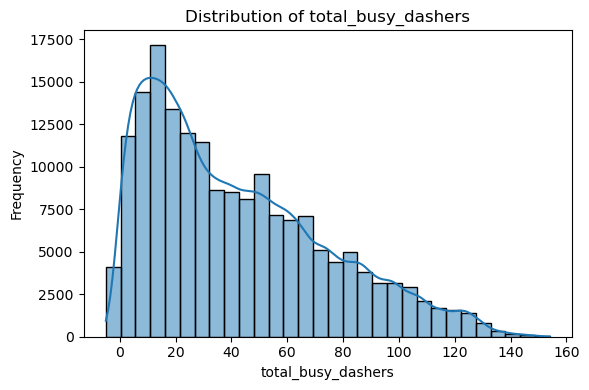

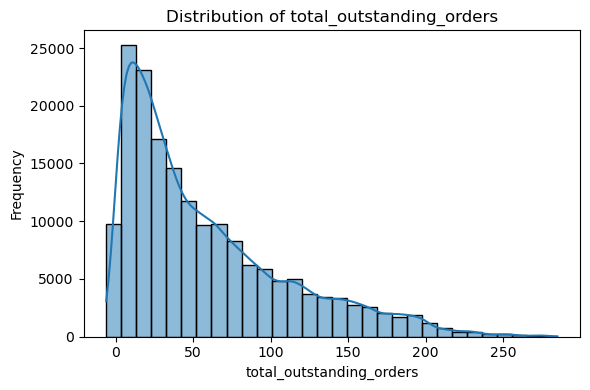

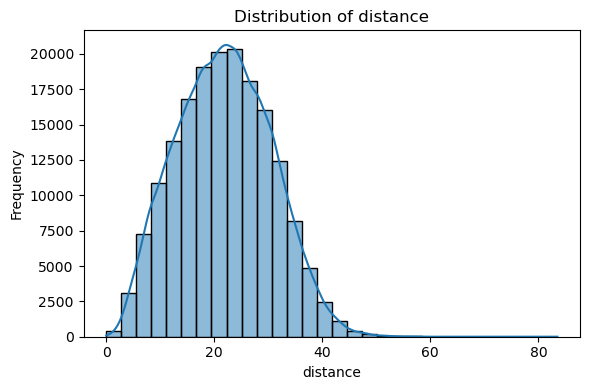

In [13]:
# Plot distributions for all numerical columns
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

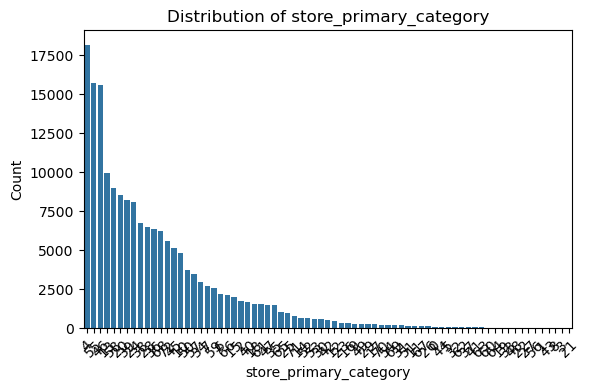

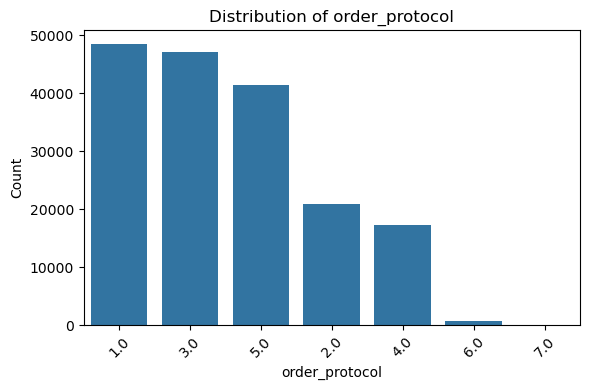

In [14]:
# Distribution of categorical columns
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

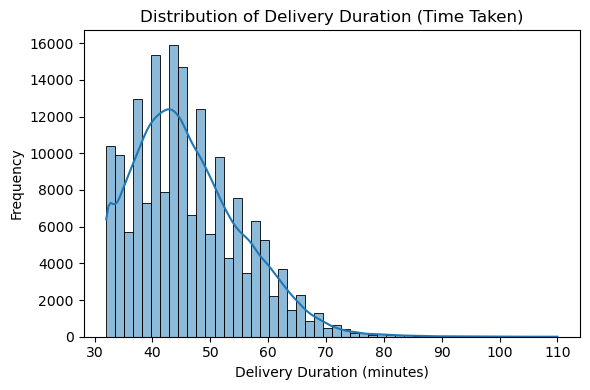

In [15]:
# Distribution of time_taken
plt.figure(figsize=(6, 4))
sns.histplot(df['delivery_duration'], kde=True, bins=50)
plt.title('Distribution of Delivery Duration (Time Taken)')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

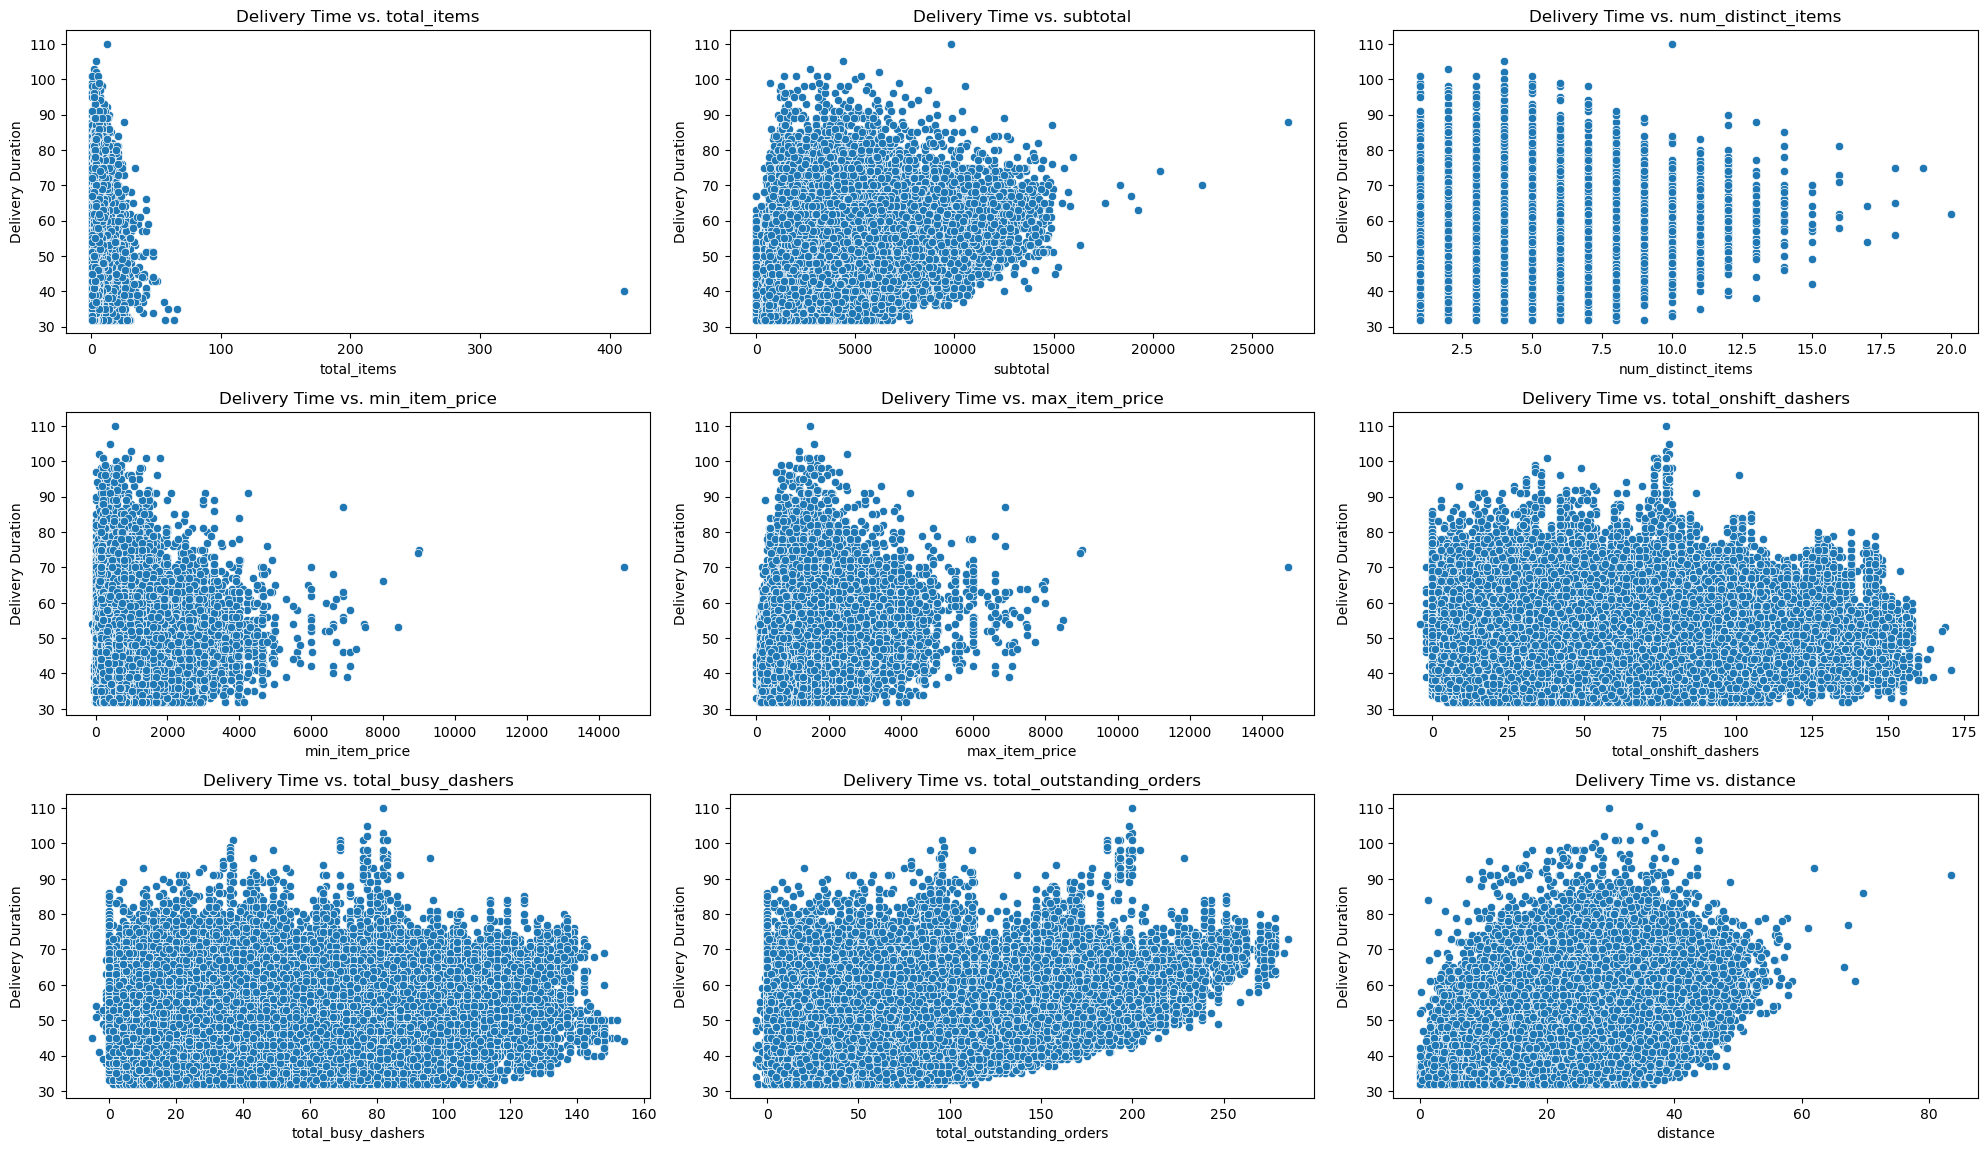

In [16]:
# Scatter plot to visualise the relationship between time_taken and other features
numerical_features = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
                      'max_item_price', 'total_onshift_dashers',
                      'total_busy_dashers', 'total_outstanding_orders', 'distance']  # Removed 'median_item_price', 'distance_to_store_km'


df['median_item_price'] = (df['min_item_price'] + df['max_item_price']) / 2

#scatter plot
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i + 1)

    if feature in df.columns:
        sns.scatterplot(x=feature, y='delivery_duration', data=df)
        plt.title(f'Delivery Time vs. {feature}')
        plt.xlabel(feature)
        plt.ylabel('Delivery Duration')
    else:
        print(f"Feature '{feature}' not found in DataFrame. Skipping plot.")

plt.tight_layout()
plt.show()


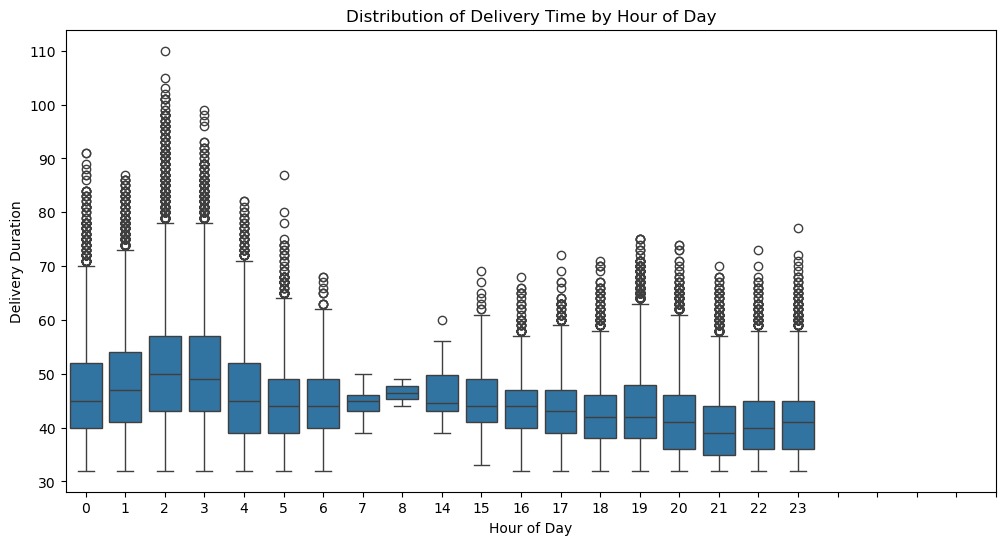

In [17]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(12, 6))
sns.boxplot(x='order_hour', y='delivery_duration', data=df)

plt.title('Distribution of Delivery Time by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Delivery Duration')

plt.xticks(range(24))

plt.show()


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

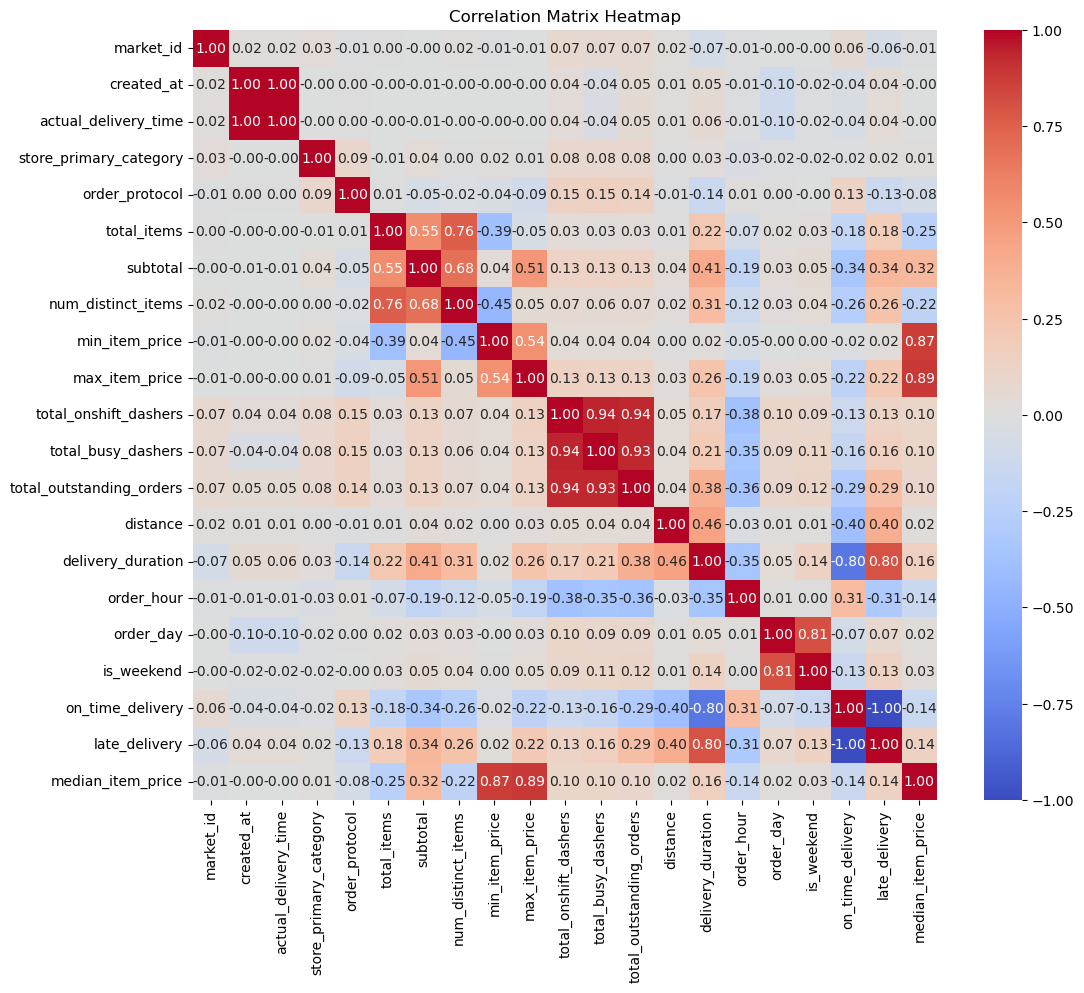

In [18]:
# Plot the heatmap of the correlation matrix
corr_matrix = df.corr()

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix Heatmap')

plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [19]:
# Drop 3-5 weakly correlated columns from training dataset
target_corr = abs(corr_matrix['delivery_duration']).sort_values(ascending=True)

weak_corr_cols = target_corr[(target_corr > 0) & (target_corr < 0.1)].index.tolist()  # You can adjust the threshold (0.1) as needed
weak_corr_cols = [col for col in weak_corr_cols if col != 'delivery_duration']  # Ensure 'delivery_duration' is excluded

cols_to_drop = weak_corr_cols[:min(5, len(weak_corr_cols))]  # Drop up to 5, or fewer if there are less

X_train_dropped = X_train.drop(columns=cols_to_drop, errors='ignore')  # Use errors='ignore' in case some cols are not present

print(f"Dropped columns: {cols_to_drop}")
print(f"Shape of X_train before dropping: {X_train.shape}")
print(f"Shape of X_train after dropping: {X_train_dropped.shape}")

X_train = X_train_dropped


Dropped columns: ['min_item_price', 'store_primary_category', 'order_day', 'created_at', 'actual_delivery_time']
Shape of X_train before dropping: (140621, 18)
Shape of X_train after dropping: (140621, 13)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

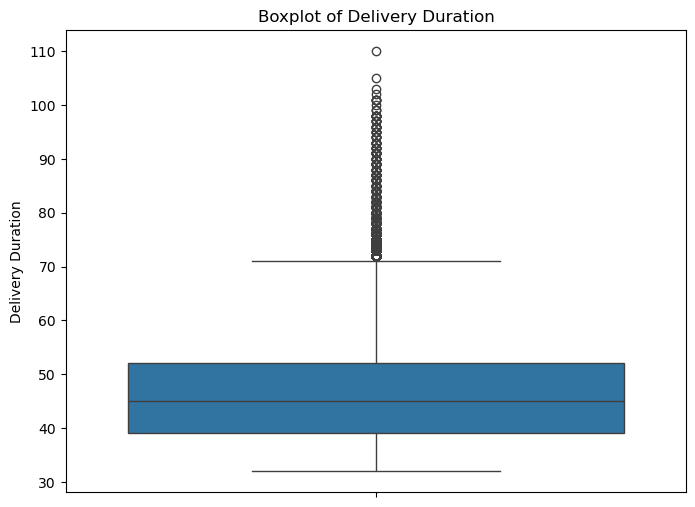

In [20]:
# Boxplot for time_taken
plt.figure(figsize=(8, 6))
sns.boxplot(y='delivery_duration', data=df)


plt.title('Boxplot of Delivery Duration')
plt.ylabel('Delivery Duration')

plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

Number of outliers before capping: 1749
Number of outliers after capping: 0


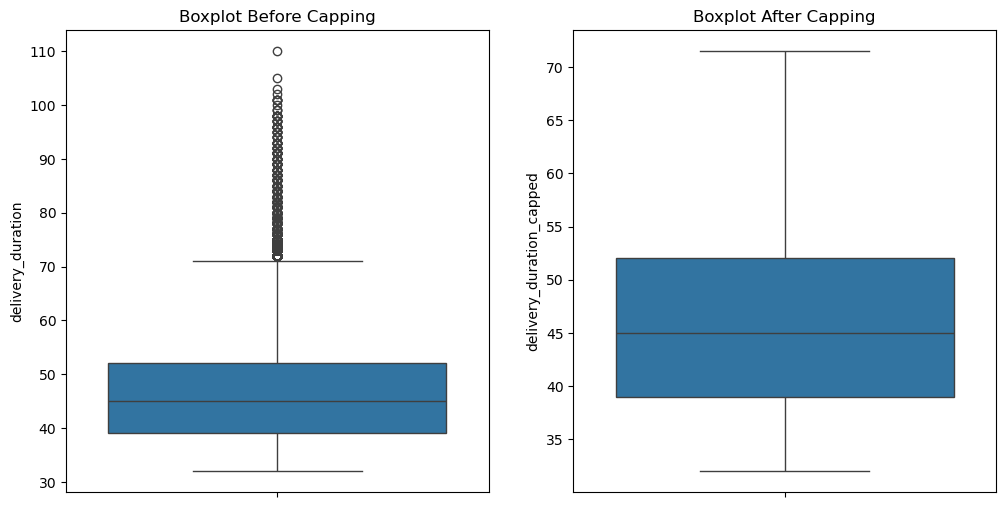

In [21]:
# Handle outliers

# 1. Calculate Q1 and Q3
Q1 = df['delivery_duration'].quantile(0.25)
Q3 = df['delivery_duration'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the outliers
df['delivery_duration_capped'] = df['delivery_duration'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

print(f"Number of outliers before capping: {len(df[(df['delivery_duration'] < lower_bound) | (df['delivery_duration'] > upper_bound)])}")
print(f"Number of outliers after capping: {len(df[(df['delivery_duration_capped'] < lower_bound) | (df['delivery_duration_capped'] > upper_bound)])}")

#  boxplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y='delivery_duration', data=df)
plt.title('Boxplot Before Capping')

plt.subplot(1, 2, 2)
sns.boxplot(y='delivery_duration_capped', data=df)
plt.title('Boxplot After Capping')

plt.show()


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [ ]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [ ]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [22]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [23]:
# Apply scaling to the numerical columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

common_numerical_cols = list(set(numerical_cols) & set(X_train.columns))

X_train[common_numerical_cols] = scaler.fit_transform(X_train[common_numerical_cols])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


X_val[common_numerical_cols] = scaler.transform(X_val[common_numerical_cols])

print("Scaled Training Data:")
print(X_train.head())

print("\nScaled Validation Data:")
print(X_val.head())


Scaled Training Data:
        market_id          created_at actual_delivery_time  \
102712        2.0 2015-02-03 21:53:57  2015-02-03 22:38:57   
94576         4.0 2015-01-23 02:21:42  2015-01-23 03:04:42   
49784         1.0 2015-02-06 21:38:32  2015-02-06 22:24:32   
37753         3.0 2015-01-27 03:06:21  2015-01-27 03:57:21   
91728         2.0 2015-02-13 21:23:39  2015-02-13 22:00:39   

       store_primary_category order_protocol  total_items  subtotal  \
102712                     45            2.0            1       820   
94576                      20            3.0            1       995   
49784                      36            3.0            4      2040   
37753                      39            1.0            2      2376   
91728                       6            1.0            1      1430   

        num_distinct_items  min_item_price  max_item_price  \
102712                   1             745             745   
94576                    1             995            

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [24]:
# Create/Initialise the model
model = LinearRegression()
print(model)

LinearRegression()


In [25]:
# Train the model using the training data
model.fit(X_train, y_train)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
# Make predictions


In [ ]:
# Find results for evaluation metrics



Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [ ]:
# Loop through the number of features and test the model



In [ ]:
# Build the final model with selected number of features



## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram



[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model



Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'



Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, there are 2 categorical variables in the data:
1. store_primary_category
2. prder_protocol



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>it means that 20% of the original dataset will be used for the test (or validation) set while the remaining 80% will be used for the training set.

---


##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>distance



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> Using IQR and boxplot



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear regression is a learning algorithm used for predicting a continuous outcome based on one or more input features.
> It assumes a linear relationship between the independent variables and the dependent variable.
> It usually represented in the liner equation y= mx + c




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple liner regression deals with only one predictor variable whereas multi linear regression deals with more than one predictor variables to predict target.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function in linear regression serves as a measure of how well the model's predictions match the actual values in the dataset.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Underfitting occurs when a model is too simple to capture the underlying patterns in the training data. It fails to learn the relationships between the input features and the target variable effectively.

>Overfitting occurs when a model learns the training data too well, including the noise and random fluctuations present in that specific dataset. It essentially memorizes the training data instead of learning the generalizable patterns.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> They help us assess whether the assumptions of linear regression are being met and identify potential problems with the model.